# Medical Text Dataset Exploratory Data Analysis, Topic Modelling Using Latent Dirichlet Allocation, and Multiclass Classification Using DistilBERT and TFIDF-XGBoost Model

<b>Kevin Putra Santoso, Department of Information Technology</b>
<br>
<b>Sepuluh Nopember Institute of Technology</b>
<hr>

Welcome to my notebook. In this notebook, I did some exploration on Medical Text Dataset for classifying cancer type based on its related scientific paper. The goal of this notebook is to:
<ol>
<li>To understand the text data by showing the top 10 frequent words</li>
<li>To implement topic modelling using LDA</li>
<li>To implement multiclass classification using the robust DistilBERT model and compare it to TFIDF-XGBoost Model</li>
</ol>

Let's get started.

1. Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

2. Load data

In [2]:
df = pd.read_csv('alldata_1_for_kaggle.csv',encoding="latin1")
df.drop(columns='Unnamed: 0', inplace=True)
df.columns = ['class', 'doc']
df = df.reindex(['doc', 'class'], axis=1)
df

,doc,class
0,Thyroid surgery in children in a single insti...,Thyroid_Cancer
1,""" The adopted strategy was the same as that us...",Thyroid_Cancer
2,coronary arterybypass grafting thrombosis ï¬b...,Thyroid_Cancer
3,Solitary plasmacytoma SP of the skull is an u...,Thyroid_Cancer
4,This study aimed to investigate serum matrix ...,Thyroid_Cancer
...,...,...
7565,we report the case of a 24yearold man who pres...,Colon_Cancer
7566,among synchronous colorectal cancers scrcs rep...,Colon_Cancer
7567,the heterogeneity of cancer cells is generally...,Colon_Cancer
7568,"""adipogenesis is the process through which mes...",Colon_Cancer


3. Text preprocessing

There will be several necessary parts for text preprocessing:
<li>Tokenizing into array</li>
<li>Removing non-alphanumeric characters</li>
<li>Removing stopwords and lemmatizing each element</li>
<li>Rejoin</li>

3.1. Tokenizing into array

In [4]:
df['textArr'] = np.nan

for i in range(len(df['doc'])):
    df['textArr'][i] = df['doc'][i].split()

C:\Users\Kevin Putra Santoso\AppData\Local\Temp\ipykernel_9252\3106744869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['textArr'][i] = df['doc'][i].split()


3.2. Removing non-alphanumeric characters

In [5]:
pattern = re.compile(r'[^\w\s]') # Clear non-alphanumeric characters
pattern2 = re.compile(r'[\s]') # Clear any existing whitespaces on each token
pattern3 = re.compile(r']') # I found ']' after clearing the text corpus using those 2 regular expressions above, so I decided to manually clear ']' element only using regex

In [6]:
for doc in range(len(df['textArr'])):
    for index in df['textArr'][doc]:
        if bool(re.search(pattern, f"{index}")) or bool(re.search(pattern2, f"{index}")) or bool(re.search(pattern3, f"{index}")):
            df['textArr'][doc].remove(index)

3.3 Removing stopwords and lemmatizing each element

In [8]:
nlp = spacy.load('en_core_web_sm')

df['lemmaArr'] = np.nan

for i in range(len(df['textArr'])):
    df['lemmaArr'][i] = " ".join(df['textArr'][i])
    df['lemmaArr'][i] = df['lemmaArr'][i].lower()

c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_core_web_sm' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\Kevin Putra Santoso\AppData\Local\Temp\ipykernel_9252\3912223258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmaArr'][i] = " ".join(df['textArr'][i])


In [9]:
df['lemmatizedArr'] = np.nan

counter = 0
for text in df['lemmaArr']:
    lemmatized = []
    text = nlp(text)
    for token in text:
        lemmatized.append(token.lemma_)
    
    df['lemmatizedArr'][counter] = lemmatized
    counter += 1

C:\Users\Kevin Putra Santoso\AppData\Local\Temp\ipykernel_9252\1006157663.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatizedArr'][counter] = lemmatized


Now the 'lemmatizedArr' column contains the cleaned tokens that have been lemmatized. Now we check each elements inside the array and remove any stopwords if exist.

In [12]:
df.head()

,doc,class,textArr,lemmaArr,lemmatizedArr
0,Thyroid surgery in children in a single insti...,Thyroid_Cancer,"[Thyroid, surgery, in, children, in, a, single...",thyroid surgery in children in a single instit...,"[thyroid, surgery, in, child, in, a, single, i..."
1,""" The adopted strategy was the same as that us...",Thyroid_Cancer,"[The, adopted, strategy, was, the, same, as, t...",the adopted strategy was the same as that used...,"[the, adopt, strategy, be, the, same, as, that..."
2,coronary arterybypass grafting thrombosis ï¬b...,Thyroid_Cancer,"[coronary, arterybypass, grafting, thrombosis,...",coronary arterybypass grafting thrombosis muta...,"[coronary, arterybypass, grafting, thrombosis,..."
3,Solitary plasmacytoma SP of the skull is an u...,Thyroid_Cancer,"[Solitary, plasmacytoma, SP, of, the, skull, i...",solitary plasmacytoma sp of the skull is an un...,"[solitary, plasmacytoma, sp, of, the, skull, b..."
4,This study aimed to investigate serum matrix ...,Thyroid_Cancer,"[This, study, aimed, to, investigate, serum, m...",this study aimed to investigate serum matrix m...,"[this, study, aim, to, investigate, serum, mat..."


In [10]:
lemmatizedArrbackup = df['lemmatizedArr'].copy()

In [11]:
for text in df['lemmatizedArr']:
    for token in text:
        if nlp.vocab[token].is_stop:
            text.remove(token)

In [12]:
df['lemmatizedText'] = np.nan

for i in range(len(df['lemmatizedArr'])):
    df['lemmatizedText'][i] = " ".join(df['lemmatizedArr'][i])

C:\Users\Kevin Putra Santoso\AppData\Local\Temp\ipykernel_9252\4280758392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatizedText'][i] = " ".join(df['lemmatizedArr'][i])


In [16]:
df

,doc,class,textArr,lemmaArr,lemmatizedArr,lemmatizedText
0,Thyroid surgery in children in a single insti...,Thyroid_Cancer,"[Thyroid, surgery, in, children, in, a, single...",thyroid surgery in children in a single instit...,"[thyroid, surgery, child, single, institution,...",thyroid surgery child single institution osama...
1,""" The adopted strategy was the same as that us...",Thyroid_Cancer,"[The, adopted, strategy, was, the, same, as, t...",the adopted strategy was the same as that used...,"[adopt, strategy, use, prior, year, base, excl...",adopt strategy use prior year base exclusive q...
2,coronary arterybypass grafting thrombosis ï¬b...,Thyroid_Cancer,"[coronary, arterybypass, grafting, thrombosis,...",coronary arterybypass grafting thrombosis muta...,"[coronary, arterybypass, grafting, thrombosis,...",coronary arterybypass grafting thrombosis muta...
3,Solitary plasmacytoma SP of the skull is an u...,Thyroid_Cancer,"[Solitary, plasmacytoma, SP, of, the, skull, i...",solitary plasmacytoma sp of the skull is an un...,"[solitary, plasmacytoma, sp, skull, uncommon, ...",solitary plasmacytoma sp skull uncommon clinic...
4,This study aimed to investigate serum matrix ...,Thyroid_Cancer,"[This, study, aimed, to, investigate, serum, m...",this study aimed to investigate serum matrix m...,"[study, aim, investigate, serum, matrix, metal...",study aim investigate serum matrix metalloprot...
...,...,...,...,...,...,...
7565,we report the case of a 24yearold man who pres...,Colon_Cancer,"[we, report, the, case, of, a, 24yearold, man,...",we report the case of a 24yearold man who pres...,"[report, case, 24yearold, man, present, chief,...",report case 24yearold man present chief compla...
7566,among synchronous colorectal cancers scrcs rep...,Colon_Cancer,"[among, synchronous, colorectal, cancers, scrc...",among synchronous colorectal cancers scrcs rep...,"[synchronous, colorectal, cancer, scrc, report...",synchronous colorectal cancer scrc report prev...
7567,the heterogeneity of cancer cells is generally...,Colon_Cancer,"[the, heterogeneity, of, cancer, cells, is, ge...",the heterogeneity of cancer cells is generally...,"[heterogeneity, cancer, cell, generally, accep...",heterogeneity cancer cell generally accept ast...
7568,"""adipogenesis is the process through which mes...",Colon_Cancer,"[is, the, process, through, which, mesenchymal...",is the process through which mesenchymalstem c...,"[process, mesenchymalstem, cell, msc, commit, ...",process mesenchymalstem cell msc commit adipos...


Bingo! By cleaning the text corpus, now we can perform some exploratory data analysis and topic modelling using LDA.

4. Topic Modelling

In [13]:
data_lemmatized = df['lemmatizedText'].values.tolist()

In [14]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=14,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             )

lemmaTextVectorized = vectorizer.fit_transform(data_lemmatized)
lemmaTextDense = lemmaTextVectorized.todense()
print(f"Sparsity of text data: {((lemmaTextDense > 0).sum() / lemmaTextDense.size) *100} %")

Sparsity of text data: 1.4210166488884206 %


In [26]:
model = LatentDirichletAllocation(n_components=7,           # Number of topics
                                max_iter=20,              # Max learning iterations
                                learning_method='online',
                                learning_decay=0.3,   
                                random_state=142,          # Random state
                                batch_size=128,            # n docs in each learning iter
                                evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                n_jobs = -1)

model.fit(lemmaTextVectorized)

LatentDirichletAllocation(learning_decay=0.3, learning_method='online',
                          max_iter=20, n_components=7, n_jobs=-1,
                          random_state=142)

In [27]:
print("Model Perplexity: ", model.perplexity(lemmaTextVectorized))

Model Perplexity:  2889.0191102705203


It seems that the LDA Model has a high model perplexity, but this is caused by the lack of diversity of the training data (since most of them talk about cancer). But by applying LDA, we expect to find some essential topics or entities within the data. Therefore we can overlook this for now.

In [28]:
pyLDAvis.enable_notebook(local=True)

panel = pyLDAvis.sklearn.prepare(model, lemmaTextVectorized, vectorizer, mds='tsne')

pyLDAvis.save_html(panel, 'lda_result.html')

c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [29]:
from IPython.display import display, HTML

display(HTML('lda_result.html'))

5. Plotting Top 10 Frequent Words and Visualizing Text Corpus Using Wordcloud

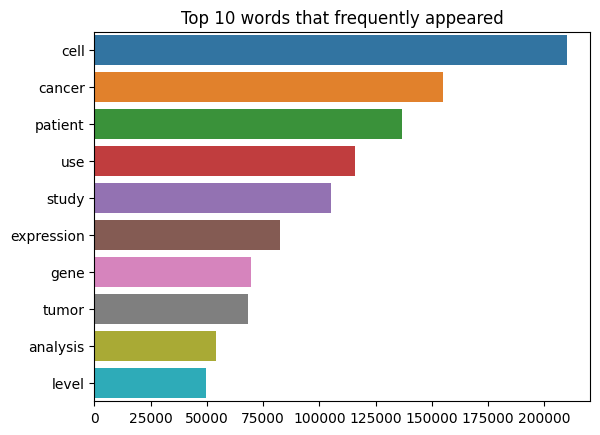

In [35]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:13]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    
    plt.title("Top 10 words that frequently appeared")
    sns.barplot(x = y, y = x)

plot_top_non_stopwords_barchart(df['lemmatizedText'])

c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\Kevin Putra Santoso\anaconda3\envs\torch-env\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated a

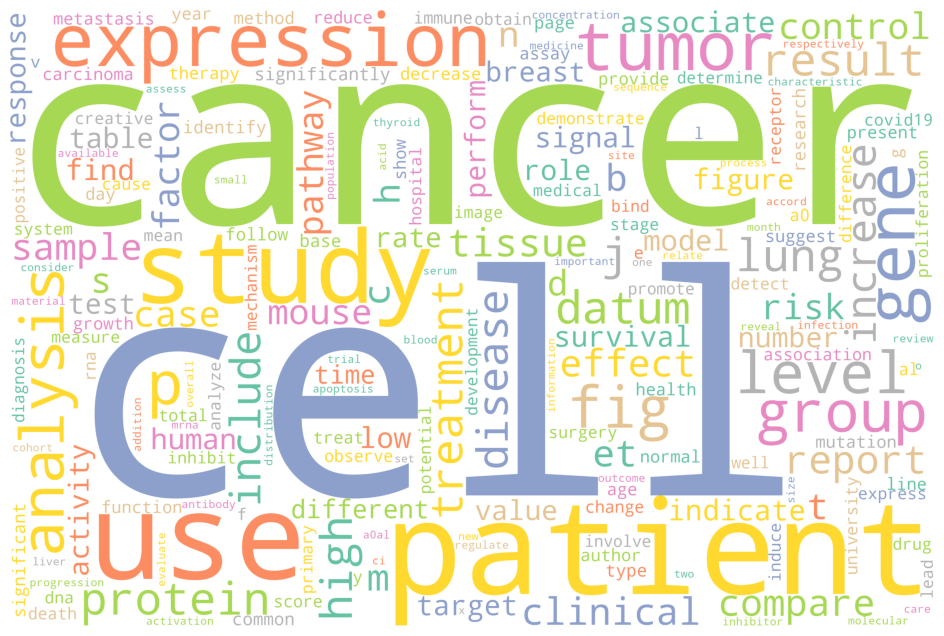

In [36]:
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud) 
    plt.axis("off")

all_words = ' '.join([text for text in df['lemmatizedText']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=3, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(all_words)
plot_cloud(wordcloud)

6. Multiclassification Modelling Using DistilBert

In [119]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2")
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1")

In [120]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [40]:
df_save = df[['doc', 'class', 'lemmaArr', 'lemmatizedText']]

In [42]:
df_save.to_csv('data_update.csv', index=False)

In [44]:
ohe_target = pd.get_dummies(df_save['class'])
df_save = pd.concat([df_save, ohe_target], axis=1)
df_save.drop(columns='class', inplace=True)

In [121]:
df_save.head()

,doc,lemmaArr,lemmatizedText,Colon_Cancer,Lung_Cancer,Thyroid_Cancer
0,Thyroid surgery in children in a single insti...,thyroid surgery in children in a single instit...,thyroid surgery child single institution osama...,0,0,1
1,""" The adopted strategy was the same as that us...",the adopted strategy was the same as that used...,adopt strategy use prior year base exclusive q...,0,0,1
2,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass grafting thrombosis muta...,coronary arterybypass grafting thrombosis muta...,0,0,1
3,Solitary plasmacytoma SP of the skull is an u...,solitary plasmacytoma sp of the skull is an un...,solitary plasmacytoma sp skull uncommon clinic...,0,0,1
4,This study aimed to investigate serum matrix ...,this study aimed to investigate serum matrix m...,study aim investigate serum matrix metalloprot...,0,0,1


In [122]:
X = df_save[df_save.columns[0]] # I took the uncleaned data since we are going to preprocess it using the built-in distilBERT preprocessor
y = df_save[df_save.columns[3:]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

In [123]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [124]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                      
                                                                                                  
 keras_layer_5 (KerasLayer)     {'pooled_output': (  134734080   ['keras_layer_4[0][0]',   

In [127]:
from keras.optimizers import Adam

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

history = model.fit(X_train, y_train,
                    epochs = 20, 
                    batch_size = 32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[cp])

Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.5973

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 199s 1s/step - loss: 0.8891 - accuracy: 0.5973 - val_loss: 0.7763 - val_accuracy: 0.7338
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7743

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 154s 811ms/step - loss: 0.6987 - accuracy: 0.7743 - val_loss: 0.6441 - val_accuracy: 0.8322
Epoch 3/20
190/190 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.8433

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 160s 842ms/step - loss: 0.5892 - accuracy: 0.8433 - val_loss: 0.5561 - val_accuracy: 0.8666
Epoch 4/20
190/190 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8727

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 165s 869ms/step - loss: 0.5114 - accuracy: 0.8727 - val_loss: 0.4895 - val_accuracy: 0.9082
Epoch 5/20
190/190 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.8981

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 164s 862ms/step - loss: 0.4549 - accuracy: 0.8981 - val_loss: 0.4410 - val_accuracy: 0.9003
Epoch 6/20
190/190 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.9135

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 163s 859ms/step - loss: 0.4074 - accuracy: 0.9135 - val_loss: 0.3992 - val_accuracy: 0.9168
Epoch 7/20
190/190 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.9212

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 165s 866ms/step - loss: 0.3736 - accuracy: 0.9212 - val_loss: 0.3703 - val_accuracy: 0.9095
Epoch 8/20
190/190 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.9310

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 164s 864ms/step - loss: 0.3430 - accuracy: 0.9310 - val_loss: 0.3376 - val_accuracy: 0.9452
Epoch 9/20
190/190 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.9371

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 163s 855ms/step - loss: 0.3186 - accuracy: 0.9371 - val_loss: 0.3167 - val_accuracy: 0.9458
Epoch 10/20
190/190 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.9411

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 162s 854ms/step - loss: 0.2991 - accuracy: 0.9411 - val_loss: 0.2926 - val_accuracy: 0.9557
Epoch 11/20
190/190 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9496

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 172s 904ms/step - loss: 0.2786 - accuracy: 0.9496 - val_loss: 0.2751 - val_accuracy: 0.9544
Epoch 12/20
190/190 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9477

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 167s 881ms/step - loss: 0.2640 - accuracy: 0.9477 - val_loss: 0.2595 - val_accuracy: 0.9610
Epoch 13/20
190/190 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9529

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 164s 865ms/step - loss: 0.2511 - accuracy: 0.9529 - val_loss: 0.2446 - val_accuracy: 0.9597
Epoch 14/20
190/190 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9529

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 202s 1s/step - loss: 0.2376 - accuracy: 0.9529 - val_loss: 0.2360 - val_accuracy: 0.9610
Epoch 15/20
190/190 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9586

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 195s 1s/step - loss: 0.2219 - accuracy: 0.9586 - val_loss: 0.2255 - val_accuracy: 0.9617
Epoch 16/20
190/190 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9624

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 168s 881ms/step - loss: 0.2133 - accuracy: 0.9624 - val_loss: 0.2069 - val_accuracy: 0.9723
Epoch 17/20
190/190 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9642

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 166s 873ms/step - loss: 0.2052 - accuracy: 0.9642 - val_loss: 0.1973 - val_accuracy: 0.9756
Epoch 18/20
190/190 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9653

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 168s 881ms/step - loss: 0.1951 - accuracy: 0.9653 - val_loss: 0.1882 - val_accuracy: 0.9775
Epoch 19/20
190/190 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9675

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 169s 890ms/step - loss: 0.1860 - accuracy: 0.9675 - val_loss: 0.1809 - val_accuracy: 0.9775
Epoch 20/20
190/190 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9668

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


190/190 [==============================] - 162s 852ms/step - loss: 0.1801 - accuracy: 0.9668 - val_loss: 0.1729 - val_accuracy: 0.9835


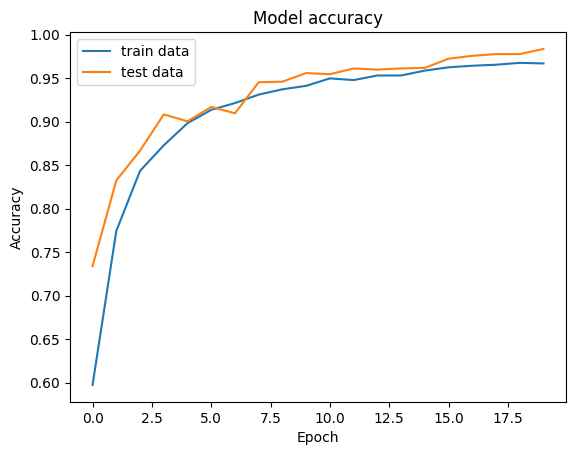

In [129]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train data', 'test data'], loc='upper left')
plt.show()

In [130]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=list(y_test.columns))

y_test_list = []
y_pred_list = []

for i in range(len(y_pred)):
    y_test_list.append(y_test.columns[np.argmax(y_test.iloc[i])])
    y_pred_list.append(y_pred.columns[np.argmax(y_pred.iloc[i])])

48/48 [==============================] - 30s 591ms/step


                precision    recall  f1-score   support

  Colon_Cancer     0.9711    0.9882    0.9796       510
   Lung_Cancer     1.0000    0.9911    0.9955       450
Thyroid_Cancer     0.9818    0.9729    0.9773       554

      accuracy                         0.9835      1514
     macro avg     0.9843    0.9841    0.9842      1514
  weighted avg     0.9836    0.9835    0.9835      1514



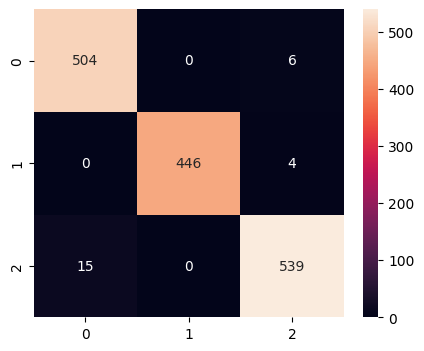

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_list, y_pred_list, digits=4))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_list, y_pred_list), annot=True, fmt='.0f')
plt.show()

7. Model Comparation With TFIDF-XGBoost

In [149]:
X_2 = df_save[df_save.columns[2]]

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=142)

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)

In [150]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

clf_txt = Pipeline([('tfidf', TfidfVectorizer()), ('clf', XGBClassifier())])
clf_txt.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [151]:
y_pred = clf_txt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=list(y_test.columns))

y_test_list = []
y_pred_list = []

for i in range(len(y_pred)):
    y_test_list.append(y_test.columns[np.argmax(y_test.iloc[i])])
    y_pred_list.append(y_pred.columns[np.argmax(y_pred.iloc[i])])

                precision    recall  f1-score   support

  Colon_Cancer     1.0000    1.0000    1.0000       510
   Lung_Cancer     1.0000    1.0000    1.0000       450
Thyroid_Cancer     1.0000    1.0000    1.0000       554

      accuracy                         1.0000      1514
     macro avg     1.0000    1.0000    1.0000      1514
  weighted avg     1.0000    1.0000    1.0000      1514



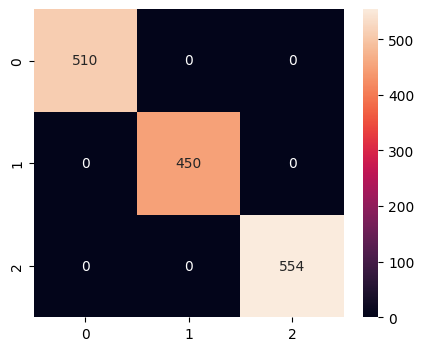

In [152]:
print(classification_report(y_test_list, y_pred_list, digits=4))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_list, y_pred_list), annot=True, fmt='.0f')
plt.show()

It seems that TFIDF-XGBoost wins against DistilBERT model in this dataset. This might be caused by several reasons:
<li>TFIDF preprocessing method works more effectively in this dataset</li>
<li>DistilBERT model should be fine-tuned more in order to obtain higher accuracy</li>

That concludes my project on this notebook! Please, feel free to give any feedback to improve this project.